In [1]:
import numpy as np
import torch

In [2]:
def Rot(phi, eta, omega):
    return np.array([[np.exp(-1j*(omega+eta)/2)*np.cos(phi/2), -np.exp(1j*(omega-eta)/2)*np.sin(phi/2)],
                        [np.exp(-1j*(omega-eta)/2)*np.sin(phi/2), np.exp(1j*(omega+eta)/2)*np.cos(phi/2)]])

def Rot_2wire(angles1, angles2):
    rot1 = Rot(*angles1)
    rot2 = Rot(*angles2)
    U = np.empty((4, 4), dtype=np.complex128)
    U[:2,:2] = rot1 * rot2[0, 0]    
    U[:2,2:] = rot1 * rot2[0, 1]
    U[2:,:2] = rot1 * rot2[1, 0]
    U[2:,2:] = rot1 * rot2[1, 1]
    return U

def CNOTS():
    return np.array([[1, 0, 0, 0],[0, 0, 0, 1],[0, 1, 0, 0],[0, 0, 1, 0]])

def Target():
    return np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]])

In [148]:
def Calculate_U(params):
    U = np.eye(4)
    for layer in params:
        U = Rot_2wire(*layer) @ U
        U = CNOTS() @ U
    return U

In [149]:
def rejection_sample(n = 100000):
    t = np.expand_dims(Target(), axis=0)
    best = (np.zeros((3, 2, 3)), np.eye(4), 4)
    for i in range(n):
        samples = np.random.uniform(high=np.pi, size=(3, 2, 3))
        U = Calculate_U(samples)
        loss = np.sum(np.abs((t - U)))
        if loss < best[2]:
            best = (samples, U, loss)
    return best
        

In [150]:
rejection_sample()

(array([[[0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.]]]),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 4)

In [15]:
def Rot(phi, eta, omega):
    return torch.stack([torch.exp(-1j*(omega+eta)/2)*torch.cos(phi/2), -torch.exp(1j*(omega-eta)/2)*torch.sin(phi/2),
                        torch.exp(-1j*(omega-eta)/2)*torch.sin(phi/2), torch.exp(1j*(omega+eta)/2)*torch.cos(phi/2)]).reshape(2, 2)

def Rot_2wire(angles1, angles2):
    rot1 = torch.tile(Rot(*angles1), (2, 2))
    rot2 = torch.repeat_interleave(torch.repeat_interleave(Rot(*angles2), 2, dim=1), 2, dim=0)
    
    U = rot1 * rot2
    #U = torch.empty((4, 4), dtype=torch.cfloat, requires_grad=True)
    #U[:2,:2] = rot1 * rot2[0, 0]    
    #U[:2,2:] = rot1 * rot2[0, 1]
    #U[2:,:2] = rot1 * rot2[1, 0]
    #U[2:,2:] = rot1 * rot2[1, 1]
    return U

def CNOTS():
    return torch.tensor([[1, 0, 0, 0],[0, 0, 0, 1],[0, 1, 0, 0],[0, 0, 1, 0]], dtype=torch.cfloat)

def Target():
    return torch.tensor([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]], dtype=torch.cfloat)

def Calculate_U(params):
    U = torch.eye(4, dtype=torch.cfloat)
    for layer in params:
        U = Rot_2wire(*layer) @ U
        U = CNOTS() @ U
    return U

In [16]:
angles = torch.nn.Parameter(torch.rand((3, 2, 3))*2*np.pi - np.pi, requires_grad=True)

phase = torch.nn.Parameter(torch.rand(1)*2*np.pi-np.pi, requires_grad=True)

opt = torch.optim.SGD([angles, phase], lr=0.001, momentum=0.8)

def train(n=10000):
    target = Target()
    
    for i in range(n):
        opt.zero_grad()
        U = Calculate_U(angles)
        loss = torch.sum(torch.abs(U - torch.exp(phase*1j)*target))
        loss.backward()
        opt.step()
    return loss

In [17]:
train()

tensor(0.0220, grad_fn=<SumBackward0>)

In [18]:
print((torch.exp(-phase*1j)*Calculate_U(angles)).float())

tensor([[ 1.0000e+00, -1.6764e-03, -8.4633e-04,  4.9473e-04],
        [ 1.6726e-03,  1.0000e+00, -1.0332e-03,  8.5101e-04],
        [-4.9805e-04, -8.5343e-04,  1.6715e-03,  9.9999e-01],
        [ 8.4878e-04,  1.0319e-03,  1.0000e+00, -1.6743e-03]],
       grad_fn=<ToCopyBackward0>)


In [19]:
print(angles/np.pi)

tensor([[[-1.0006,  0.6841, -1.0260],
         [-1.5000,  0.3777, -0.9996]],

        [[-0.5003,  1.0001,  0.7028],
         [ 0.5006, -0.7293,  0.5000]],

        [[ 0.5000,  0.2106,  0.7285],
         [ 0.4187, -0.5003,  0.4994]]], grad_fn=<DivBackward0>)


In [22]:
phase/np.pi

tensor([-0.7502], grad_fn=<DivBackward0>)

In [179]:
constructed = torch.tensor([[[2/15, 3/2, 3/2], [1/2, 23/20, 3/2]], 
                            [[1/2, 2, 7/20], [27/2, 2/5, 1/2]], 
                            [[1/2, 4/25, 8/5], [1, 9/5, 8/25]]]) * np.pi

In [180]:
print(angles - constructed)

tensor([[[ 1.8469e-02,  2.0599e-04, -4.8460e-02],
         [-1.3697e-04, -5.7507e-04, -9.0122e-04]],

        [[ 7.7486e-06,  4.5013e-04,  2.5059e-03],
         [-3.8131e+01,  5.8014e-02,  9.7823e-04]],

        [[-2.3842e-06, -4.5276e-01, -6.2401e-02],
         [ 8.9097e-04,  6.1103e-02, -1.6272e-03]]], grad_fn=<SubBackward0>)


In [182]:
Calculate_U(angles)

tensor([[ 9.9999e-01-0.0003j,  1.7604e-04+0.0027j,  1.7783e-03+0.0002j,
          1.3077e-04+0.0026j],
        [-1.7762e-04+0.0027j,  9.9999e-01+0.0012j,  1.0744e-04-0.0022j,
          9.0281e-04-0.0003j],
        [-1.3024e-04+0.0026j, -9.0356e-04-0.0003j, -1.7667e-04+0.0027j,
          9.9999e-01+0.0004j],
        [ 1.7792e-03-0.0002j,  1.0780e-04+0.0022j, -9.9999e-01+0.0013j,
         -1.7767e-04-0.0027j]], grad_fn=<MmBackward0>)

In [13]:
from copy import copy

In [14]:
def CNOTS_n_qubit(n=2):
    mat = np.eye(2**n)
    for i in range(n):
        ctrl = 2**(n-i-1)
        if i < n-1:
            targ = 2**(n-i-2)
        else:
            targ = 2**(n-1)
        for j in range(len(mat)):
            if j % (ctrl*2) >= ctrl:
                #ctrl bit is 1
                if j % (targ*2) < targ:
                    #targ bit is 0, swap with 1
                    tmp = copy(mat[j])
                    mat[j] = mat[j+targ]
                    mat[j+targ] = tmp
            else:
                continue
    return mat

In [17]:
CNOTS_n_qubit()

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,

In [22]:
def check_cycle(n):
    mat = np.eye(2**n)
    CNOT_mat = CNOTS_n_qubit(n) 
    for j in range(2**n-1):
        mat = CNOT_mat @ mat
    return np.sum(mat - np.eye(2**n))

In [23]:
for n in range(2, 20):
    print(check_cycle(n))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt

In [38]:
def cosine_anneal(t, T, eta_min, eta_max):
    alpha =  0.5* (np.cos(np.pi * t/T) + 1)
    return eta_max + alpha * (eta_min - eta_max)

T_max = 1e4

phase1 = int(0.3*T_max), 0.1, 1.0
phase2 = int(0.7*T_max), 1.0, 0.0001

lrs = []

for (T, eta_min, eta_max) in [phase1, phase2]:
    lrs_phase = [cosine_anneal(t, T, eta_min, eta_max) for t in range(T)]
    lrs.extend(lrs_phase)

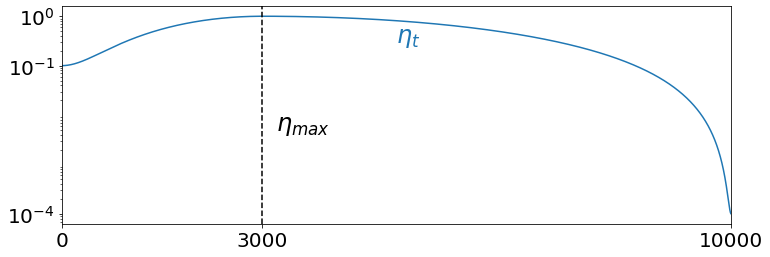

In [50]:
plt.figure(figsize=(12, 4))
plt.plot(lrs)
plt.yscale("log")
plt.yticks([1, 0.1, 0.0001], fontsize=20)
plt.xticks([0, 3000, 10000], fontsize=20)
plt.axvline(x=3000, linestyle="dashed", color="black")
plt.text(3200, 5.e-3, r"$\eta_{max}$", fontsize=24)
plt.text(5000, 3.e-1, r"$\eta_{t}$", color="C0", fontsize=24)
plt.xlim([0, 10000])
plt.savefig("/home/russell/Downloads/onecycle_vis.pdf")
plt.show()